In [22]:

import importlib
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from copy import deepcopy
from decimal import Decimal, getcontext, DecimalException
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties
from decimal import Decimal, getcontext, DecimalException
import math
# import quantum_dl_lib
# importlib.reload(quantum_dl_lib)
# from quantum_dl_lib import *
# from improved_robustness import binary_search_intersection, quantum_advantage_size_by_year, find_largest_problem_size



In [23]:


# enhanced binary search intersection robust version for large numbers
# default tolerance is 1e-5
def binary_search_intersection(
    func1, func2, low, high, tolerance=1e-9, max_iterations=100000
) -> float:
    """
    Find the intersection of two functions f1(x)=func1(x) and f2(x)=func2(x) (i.e. where f1(x)==f2(x))
    using a robust binary search approach that can handle enormous numbers.

    This version avoids evaluating huge numbers directly by using a "safe" evaluation routine.
    It assumes that on the search interval the functions are positive (so logarithms make sense)
    and that the difference f(x)=func1(x)-func2(x) is monotonic.

    Args:
        func1, func2: The two functions.
        low, high: The endpoints of the search interval.
        tolerance: The acceptable error for f(x) (or its logarithmic version).
        max_iterations: Maximum iterations to try.

    Returns:
        The x-value where the functions intersect, or None if no intersection was found.
    """
    # Use high precision for interval arithmetic.
    getcontext().prec = 100
    low = Decimal(str(low))
    high = Decimal(str(high))
    tol = Decimal(str(tolerance))

    def safe_f(x_dec: Decimal) -> float:
        """
        Evaluate f(x)=func1(x)-func2(x) in a way that avoids overflow.

        If one (or both) function evaluations results in a value that overflows (or is infinite),
        we assign float('inf') to that value. In the case that both are infinite (e.g. for enormous x)
        we instead compare their logarithms.

        Returns:
            A float representing the difference, or the difference of logarithms if needed.
        """
        x = float(x_dec)
        try:
            v1 = func1(x)
        except OverflowError:
            v1 = float("inf")
        try:
            v2 = func2(x)
        except OverflowError:
            v2 = float("inf")

        # If either function evaluates to infinity (or a value that compares as such), we replace it.
        if math.isinf(v1) or math.isinf(v2):
            # If both are infinite and positive, try to compare their logarithms.
            if v1 > 0 and v2 > 0 and math.isinf(v1) and math.isinf(v2):
                try:
                    log_v1 = math.log(func1(x))
                except (OverflowError, ValueError):
                    log_v1 = float("inf")
                try:
                    log_v2 = math.log(func2(x))
                except (OverflowError, ValueError):
                    log_v2 = float("inf")
                return log_v1 - log_v2
            # Otherwise, if only one is infinite, the difference will have the sign of the finite number.
            # (If v1 is infinite and v2 is not, f(x) is positive; if v2 is infinite, f(x) is negative.)
            if math.isinf(v1) and not math.isinf(v2):
                return float("inf")
            if math.isinf(v2) and not math.isinf(v1):
                return -float("inf")
        return v1 - v2

    # Evaluate at the endpoints.
    try:
        f_low = safe_f(low)
        f_high = safe_f(high)
    except (OverflowError, ValueError, DecimalException) as e:
        print("Error evaluating function at endpoints:", e)
        return None

    # Check that f(low) and f(high) bracket a sign change.
    if f_low * f_high > 0:
        # print("No sign change in f(x) over the interval; intersection not guaranteed.")
        return None

    for i in range(max_iterations):
        mid = (low + high) / 2
        f_mid = safe_f(mid)

        # If we are close enough, return.
        if abs(f_mid) < float(tol):
            return float(mid)

        # Decide which side of the interval contains the sign change.
        if f_low * f_mid < 0:
            high = mid
            f_high = f_mid
        else:
            low = mid
            f_low = f_mid

        # If the interval has shrunk sufficiently, exit.
        if abs(high - low) < tol:
            return float(mid)

    # print(f"No intersection found within {max_iterations} iterations")
    return None


# #constants in different format
fidelity_improvement_rate = 0.28
gate_speed_improvement_rate = 0.14
classical_speed_init = 1 / (1.5 * 1e9)  #Nividia H100 GPU clock speed 
superconducting_gate_speed_init = 1e-6  # (1/(1.5*1e9))*(10**3.78) # seconds #overhead taken from quantum economic advantage calculator
initial_error = 10 ** (-2.5) #initial error from error graphs 
classical_speed_improvement_rate = 0.3  # moore's law improvement
number_of_processors = 1e8  # processor overehead done from calculations for GPUs
# time_upper_limt = 3.14*1e7 # 1-year of seconds
connectivity_penalty_exponent = 0.0  # connectivity penalty for physical to logical qubit ratio in this range. default no asymptotic connectivity penality
time_upper_limit =  (3.14 * 1e7) / 12  # 1 month computation time
scode_init_speed_overhead = 1e2  # slowdown overhead from Choi, Neil, and Moses
alg_overhead_qubit = 1e0  # algorithm overhead in logical qubits
alg_overhead_qspeed = 1e0  # algorithm speed overhead based on constants this is exclusivly for quantum algorithm
classical_alg_overhead = 1e0
MAX_PROBLEM_SIZE = 1e51
MIN_YEAR = 2025
MAX_YEAR = 2050

# aggressive projection
# constants in different format
# fidelity_improvement_rate = .28
# gate_speed_improvement_rate = .14
# classical_speed_init = 1/(5*1e9) # seconds
# superconducting_gate_speed_init = (1/(5*1e9))*(10**3.78) # seconds #overhead taken from quantum economic advantage calculator
# initial_error = 10**(-2.5)
# classical_speed_improvement_rate = 0.3
# number_of_processors = 1e5
# # time_upper_limt = 3.14*1e7 # 1-year of seconds
# connectivity_penalty_exponent = 0.0 #connectivity penalty for physical to logical qubit ratio in this range.
# time_upper_limit = (3.14*1e7)/12 # 1 week computation time
# surface_code_overhead = 1e2 # number from Choi, Neil, and Moses
# MAX_PROBLEM_SIZE = 1e50
# MIN_YEAR = 2025
# MAX_YEAR = 2050

# default quantum and classical runtime if not specified
classical_runtime = "n**3"
quantum_runtime = "n"

IBM_ROADMAP = {
    2020: 27,
    2022: 127,
    2024: 133,
}
GOOGLE_ROADMAP = {
    2019: 53,
    2024: 105,
}
PERCENTILE_95_ROADMAP = {
    2025: 1662,
    2030: 15660,
}
SOTA_ROADMAP = {
    2025: 1959,
    2030: 24352,
}
percentile_90_roadmap = {
   2025:305.13,
   2030:1315
}

default_roadmap = percentile_90_roadmap


# gives the physical to logical overhead based on the surface code formula
def surface_code_formula(pP: float) -> float:
    pL = 1e-18
    pth = 1e-2
    numerator = 4 * math.log(math.sqrt(10 * pP / pL))
    denominator = math.log(pth / pP)
    fraction = numerator / denominator
    f_QEC = (fraction + 1) ** -2
    return f_QEC**-1


def problem_size_qubit_feasible(
    year: int, roadmap: dict = default_roadmap,  alg_overhead: float = 1, q_prob_size="log"
) -> float:

    # fit exponential to roadmap
    years = np.array(list(roadmap.keys()))
    qubits = np.array(list(roadmap.values()))
    min_year = min(years)
    # initial gues
    p0 = [min(qubits), 0.5, 0]

    # fit an exponential curve to the data
    def exp_func(x, a, b, c):
        return a * np.exp(b * (x - min_year)) + c

    try:
        popt, _ = curve_fit(
            exp_func, years, qubits, p0=p0, bounds=([0, -2, -1000], [10000, 2, 1000])
        )
    except RuntimeError:
        # print(f"Fitting failed for {label}")
        return None
    surf_overhead = surface_code_formula(
        initial_error * (1-fidelity_improvement_rate) ** (year - 2025)
    )
    if q_prob_size == "log":
        qubit_number = min(
            exp_func(year, *popt) / (surf_overhead * alg_overhead_qubit),
            np.log2(MAX_PROBLEM_SIZE),
        )
        return 2 ** (qubit_number)
    else:
        return min(
            exp_func(year, *popt) / (surf_overhead * alg_overhead_qubit),
            MAX_PROBLEM_SIZE,
        )


# quantum speed per operation function
def quantum_seconds_per_operation(year):
    gate_speed = superconducting_gate_speed_init * (
        1 - gate_speed_improvement_rate
    ) ** (year - 2025)
    # with error correction
    fidelity_year = initial_error * (1-fidelity_improvement_rate) ** (year - 2025)
    proportional_change = (surface_code_formula(fidelity_year)) / surface_code_formula(
        initial_error
    )
    return gate_speed * scode_init_speed_overhead * proportional_change ** (1.5)


# seconds per effective operation ie here we factor in parallelism
def classical_seconds_per_operation(year):
    # just dividing by number of processors here for now to simplify things
    return (
        1e-9
        * (1 - classical_speed_improvement_rate) ** (year - 2025)
        / number_of_processors
    )


# maximum problem size that can be solved on a quantum computer in a given amount of time at a given year
def find_largest_problem_size(
    runtime_string,
    year: int,
    quantum=True,
    qadv_only=False,
    roadmap: dict = default_roadmap,
    stagnation_year=2200,
    time_upper_limit=time_upper_limit,
    q_prob_size="log",
) -> float:
    # Constants
    try:
        # Convert string expression to lambda function
        n = sp.Symbol("n")
        expr = sp.sympify(runtime_string)
        expr = expr * n**connectivity_penalty_exponent * alg_overhead_qspeed
        # Apply connectivity penalty to the runtime
        runtime_func = sp.lambdify(n, expr)

        if quantum:
            quantum_total = lambda size: quantum_seconds_per_operation(
                year
            ) * runtime_func(size)

            def quantum_limit(x):
                return time_upper_limit  # number of seconds in a year
                # return q_ops_second_dollar

            qadv = binary_search_intersection(
                quantum_total, quantum_limit, low=2.5, high=1e50
            )
            if qadv is None:
                # print(f"No intersection found between quantum total and limit for year {year}")
                qadv = float("inf")
            # except Exception as e:
            #     print(f"Error finding intersection for year {year}: {e}")
            #     return float("inf")

            size_feasible = problem_size_qubit_feasible(
                roadmap=roadmap, year=year, q_prob_size=q_prob_size
            )
            # Handle the case where size_feasible is None
            if size_feasible is None:
                print(f"No feasible size found for year {year}. Returning infinity.")
                return float("inf")  # Return infinity if no feasible size is found
            if not qadv_only:
                return min(qadv, size_feasible)
            else:
                return qadv

        else:

            def classical_cost(x):
                if year < stagnation_year:
                    return classical_seconds_per_operation(year) * runtime_func(x)
                else:
                    return classical_seconds_per_operation(
                        stagnation_year
                    ) * runtime_func(x)

            def classical_limit(x):
                return time_upper_limit
                # return ops_second_dollar

            return binary_search_intersection(
                classical_cost, classical_limit, low=2.5, high=1e50
            )

    except Exception as e:
        print(f"Error in function evaluation: {e}")
        return None


def quantum_advantage_size_by_year(
    year, classical_runtime_string: str, quantum_runtime_string: str
) -> float:
    n = sp.symbols("n")
    class_expr = sp.sympify(classical_runtime_string)
    class_expr = (
        class_expr * classical_seconds_per_operation(year) * classical_alg_overhead
    )
    classical_runtime_func = sp.lambdify(n, class_expr)

    quant_expr = sp.sympify(quantum_runtime_string)
    quant_expr = quant_expr * n**connectivity_penalty_exponent * alg_overhead_qspeed
    quant_expr = quant_expr * quantum_seconds_per_operation(year)
    quantum_runtime_func = sp.lambdify(n, quant_expr)

    # Find intersection using the original string expressions
    return binary_search_intersection(
        classical_runtime_func, quantum_runtime_func, 2.5, 1e50
    )


# this is the intersection of quantum advantage size by year and quantum problem size qubit feasible by year
def generalized_qea(
    classical_runtime_string: str, quantum_runtime_string: str
) -> float:
    return binary_search_intersection(
        lambda x: quantum_advantage_size_by_year(
            x, classical_runtime_string, quantum_runtime_string
        ),
        lambda x: find_largest_problem_size(quantum_runtime_string, x, quantum=True),
        MIN_YEAR,
        MAX_YEAR,
    )


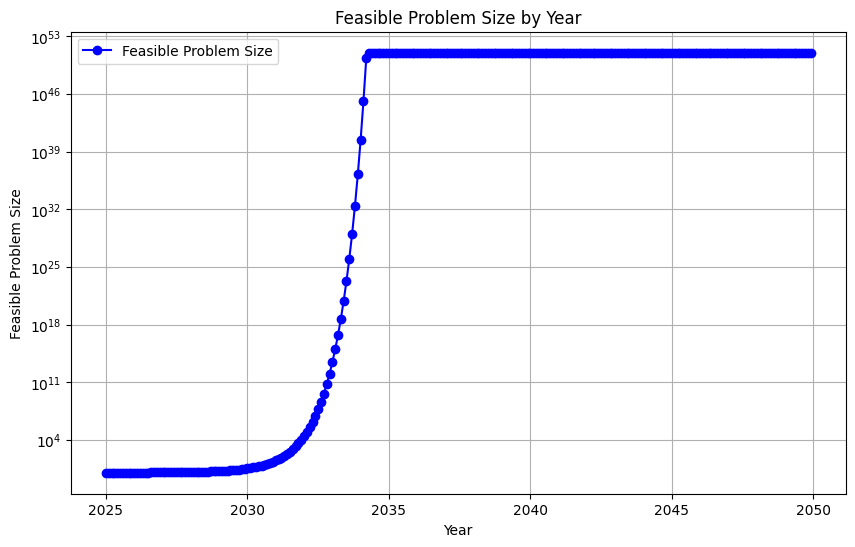

In [24]:
#graph problem_size_qubit_feasible
years = np.arange(2025, 2050, 0.1)
feasible_sizes = [problem_size_qubit_feasible(year=year) for year in years]
plt.figure(figsize=(10, 6))
plt.plot(years, feasible_sizes, marker='o', linestyle='-', color='b', label='Feasible Problem Size')
plt.xlabel('Year')
plt.ylabel('Feasible Problem Size')

plt.title('Feasible Problem Size by Year')
plt.grid(True)
plt.legend()
plt.yscale('log')

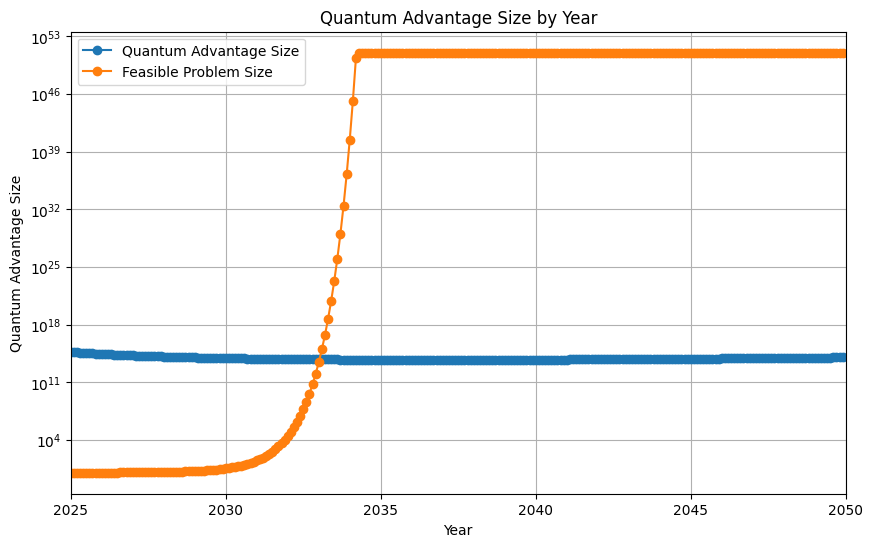

In [25]:

# Define the range of years
# years = range(2025, 2050)
years = np.arange(2025, 2050, 0.1)
classical_runtime = "n"
quantum_runtime = "log(n,2)"
# Calculate the quantum advantage size for each year
quantum_advantage_sizes = [quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime) for year in years]

# Filter out None values for plotting
filtered_years = [year for year, size in zip(years, quantum_advantage_sizes) if size is not None]
filtered_sizes = [size for size in quantum_advantage_sizes if size is not None]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(filtered_years, filtered_sizes, marker='o', linestyle='-',  label='Quantum Advantage Size')
plt.plot(years, feasible_sizes, marker='o', linestyle='-', label='Feasible Problem Size')

plt.xlabel('Year')
plt.xlim(2025, 2050)
plt.ylabel('Quantum Advantage Size')
plt.title('Quantum Advantage Size by Year')
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.show()

# Google_roadmap = {
#     2019: 54,
#     2023: 100,
#     2025: 1000,
# }




In [26]:
classical_runtime_string = "n"
quantum_runtime_string = "n**0.5"
print(generalized_qea(classical_runtime_string, quantum_runtime_string))

# def advantage_size_func(x):
#         result = quantum_advantage_size_by_year(
#             x, classical_runtime_string, quantum_runtime_string
#         )
#         if result is None:
#             return float('inf')
#         return result
        
# def feasible_size_func(x):
#     result = find_largest_problem_size(quantum_runtime_string, x, quantum=True)
#     if result is None:
#         return float('inf')
#     return result
    
# cross = binary_search_intersection(
#     advantage_size_func,
#     feasible_size_func,
#     MIN_YEAR,
#     MAX_YEAR,
#     )
# print(cross)

2033.5348307002278


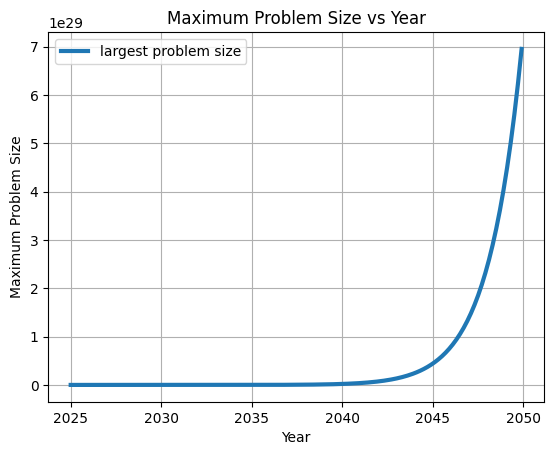

In [27]:
years = np.arange(2025, 2050, 0.1)
quantum_runtime = "n**0.5"
largest_problem_size = [find_largest_problem_size(quantum_runtime, year, quantum=True, q_prob_size="log") for year in years]
plt.plot(years, largest_problem_size, label="largest problem size", linewidth=3)
plt.xlabel("Year")
plt.ylabel("Maximum Problem Size")
plt.title("Maximum Problem Size vs Year")
plt.legend()
plt.grid(True)

# Roadmap Growth Rate Sensitivity

In [28]:
def get_intersection_year(quantum_runtime, classical_runtime,start_year=MIN_YEAR, end_year=MAX_YEAR):
    """Find intersection year for given runtime pair and roadmap"""
    def find_largest_size(year):
        return find_largest_problem_size(quantum_runtime, year, quantum=True)
    def quantum_advantage_size(year):
        return quantum_advantage_size_by_year(year, classical_runtime, quantum_runtime)

    result = binary_search_intersection(find_largest_size, quantum_advantage_size, start_year, end_year)
    return result
    # if result is None:
    #     return 2200
    # else:
    #     return result

In [29]:
# Analyze intersection years for different classical improvement rates and algorithm types
#constants in different format
fidelity_improvement_rate = 0.28
gate_speed_improvement_rate = 0.14
classical_speed_init = 1 / (1.5 * 1e9)  #
superconducting_gate_speed_init = 1e-6  # (1/(1.5*1e9))*(10**3.78) # seconds #overhead taken from quantum economic advantage calculator
initial_error = 10 ** (-2.5)
classical_speed_improvement_rate = 0.3  # moore's law improvement
number_of_processors = 1e8  # processor overehead done from calculations for GPU
connectivity_penalty_exponent = 0.0  # connectivity penalty for physical to logical qubit ratio in this range. default no 
time_upper_limit = (3.14 * 1e7) / 12  # 1 month computation time
scode_init_speed_overhead = 1e2  # slowdown overhead from Choi, Neil, and Moses
alg_overhead_qubit = 1e0  # algorithm overhead in logical qubits
alg_overhead_qspeed = 1e0  # algorithm speed overhead based on constants this is exclusivly for quantum algorithm
classical_alg_overhead = 1e0
default_roadmap = percentile_90_roadmap


default_config = {
    # Improvement rates
    "fidelity_improvement_rate": 0.28,
    "gate_speed_improvement_rate": 0.14,
    "classical_speed_improvement_rate": 0.3,  # moore's law improvement
    
    # Initial values
    "classical_speed_init": 1 / (1.5 * 1e9),
    "superconducting_gate_speed_init": 1e-6,  # seconds, overhead from quantum economic advantage calculator
    "initial_error": 10 ** (-2.5),
    
    # System parameters
    "number_of_processors": 1e8,  # processor overhead done from calculations for GPU
    "connectivity_penalty_exponent": 0.0,  # connectivity penalty for physical to logical qubit ratio
    "time_upper_limit": 4 * (3.14 * 1e7) / 52,  # 1 month computation time
    
    # Algorithm overheads
    "scode_init_speed_overhead": 1e2,  # slowdown overhead from Choi, Neil, and Moses
    "alg_overhead_qubit": 1e1,  # algorithm overhead in logical qubits
    "alg_overhead_qspeed": 1e0,  # algorithm speed overhead for quantum algorithm
    "classical_alg_overhead": 1e0,
    
    # Roadmap
    "default_roadmap": percentile_90_roadmap
}






runtime_pairs = [
    ("n", "n**.5", "Grover's Algorithm"),
    ("n", "log(n,2)", "Exponential Speedup"),
    ("n**3", "n**2", "Matrix Multiplication")
]

constant_variations = [10**i for i in range(-3, 5, 1)]


# First runtime pair: n vs n^0.5
# Define runtime pairs

# Get initial intersection years
initial_years = []
for classical_rt, quantum_rt, name in runtime_pairs:
    year = get_intersection_year(quantum_rt, classical_rt)
    initial_years.append(year)
    print(f"Initial intersection year for {name}: {year}")

# Analyze sensitivity to error reduction rate
classical_improvement_rates = np.arange(0.1, 0.9, 0.1)
intersection_results_quantum_constants = {name: [] for _, _, name in runtime_pairs}
for constant_variation in constant_variations:
    superconducting_gate_speed_init = default_config["superconducting_gate_speed_init"]*constant_variation
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, start_year=MIN_YEAR, end_year=MAX_YEAR)
        intersection_results_quantum_constants[name].append(year)


Initial intersection year for Grover's Algorithm: 2033.5348307002278
Initial intersection year for Exponential Speedup: 2033.0245721976098
Initial intersection year for Matrix Multiplication: None


Text(0.5, 1.0, 'Intersection Year vs Quantum Constants for Different Runtime Complexities')

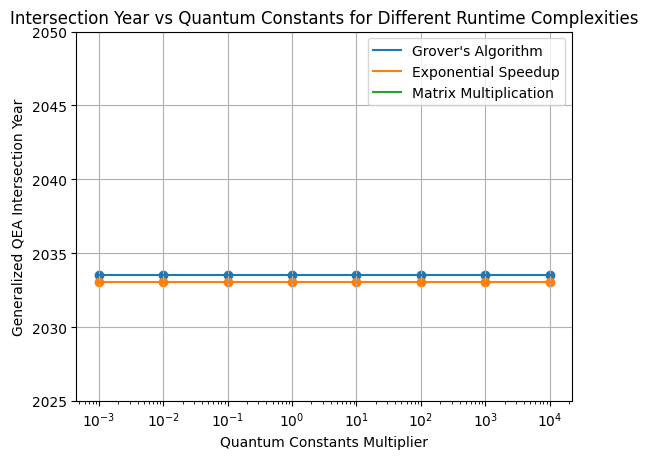

In [30]:
plt.plot(constant_variations, intersection_results_quantum_constants["Grover's Algorithm"], label="Grover's Algorithm")
plt.scatter(constant_variations, intersection_results_quantum_constants["Grover's Algorithm"])
plt.plot(constant_variations, intersection_results_quantum_constants["Exponential Speedup"], label="Exponential Speedup")
plt.scatter(constant_variations, intersection_results_quantum_constants["Exponential Speedup"])
plt.plot(constant_variations, intersection_results_quantum_constants["Matrix Multiplication"], label="Matrix Multiplication")
plt.scatter(constant_variations, intersection_results_quantum_constants["Matrix Multiplication"])
plt.ylabel("Generalized QEA Intersection Year")
plt.xlabel("Quantum Constants Multiplier")
plt.xscale("log")
plt.ylim(2025, 2050)
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig("Figures/intersection_year_vs_classical_improvement_rate.png")
plt.title("Intersection Year vs Quantum Constants for Different Runtime Complexities")

# Classical Constant Robustness

In [31]:
# Analyze intersection years for different classical improvement rates and algorithm types

fidelity_improvement_rate = 0.28
gate_speed_improvement_rate = 0.14
classical_speed_init = 1 / (1.5 * 1e9)  #
superconducting_gate_speed_init = 1e-6  # (1/(1.5*1e9))*(10**3.78) # seconds #overhead taken from quantum economic advantage calculator
initial_error = 10 ** (-2.5)
classical_speed_improvement_rate = 0.3  # moore's law improvement
number_of_processors = 1e8  # processor overehead done from calculations for GPU
connectivity_penalty_exponent = 0.0  # connectivity penalty for physical to logical qubit ratio in this range. default no 
time_upper_limit = (3.14 * 1e7) / 12  # 1 month computation time
scode_init_speed_overhead = 1e2  # slowdown overhead from Choi, Neil, and Moses
alg_overhead_qubit = 1e0  # algorithm overhead in logical qubits
alg_overhead_qspeed = 1e0  # algorithm speed overhead based on constants this is exclusivly for quantum algorithm
classical_alg_overhead = 1e0
default_roadmap = percentile_90_roadmap

# Get initial intersection years
initial_years = []
for classical_rt, quantum_rt, name in runtime_pairs:
    year = get_intersection_year(quantum_rt, classical_rt)
    initial_years.append(year)
    print(f"Initial intersection year for {name}: {year}")

# Analyze sensitivity to error reduction rate
constant_variations =[10**i for i in range(-3, 5, 1)]
intersection_results_classical_constants = {name: [] for _, _, name in runtime_pairs}

for constant_variation in constant_variations:
    classical_speed_init = default_config["classical_speed_init"]*constant_variation
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, start_year=MIN_YEAR, end_year=MAX_YEAR)
        intersection_results_classical_constants[name].append(year)


Initial intersection year for Grover's Algorithm: 2033.5348307002278
Initial intersection year for Exponential Speedup: 2033.0245721976098
Initial intersection year for Matrix Multiplication: None


Text(0.5, 1.0, 'Intersection Year vs Quantum Constants for Different Runtime Complexities')

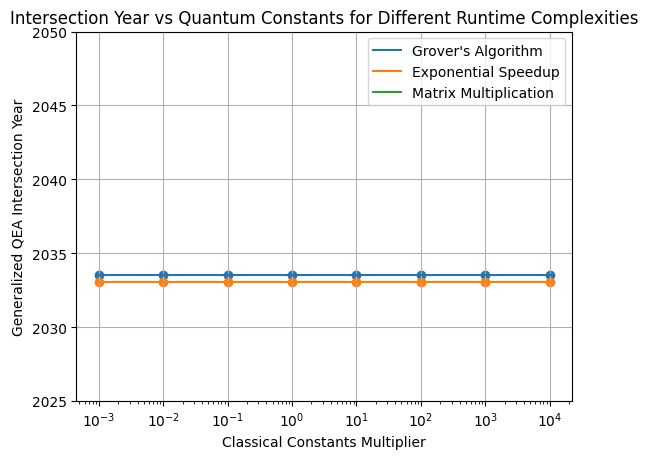

In [33]:
plt.plot(constant_variations, intersection_results_classical_constants["Grover's Algorithm"], label="Grover's Algorithm")
plt.scatter(constant_variations, intersection_results_classical_constants["Grover's Algorithm"])
plt.plot(constant_variations, intersection_results_classical_constants["Exponential Speedup"], label="Exponential Speedup")
plt.scatter(constant_variations, intersection_results_classical_constants["Exponential Speedup"])
plt.plot(constant_variations, intersection_results_classical_constants["Matrix Multiplication"], label="Matrix Multiplication")
plt.scatter(constant_variations, intersection_results_classical_constants["Matrix Multiplication"])
plt.ylabel("Generalized QEA Intersection Year")
plt.ylim(2025, 2050)
plt.xlabel("Classical Constants Multiplier")
plt.xscale("log")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig("Figures/intersection_year_vs_classical_improvement_rate.png")
plt.title("Intersection Year vs Quantum Constants for Different Runtime Complexities")

# Sensitivity Error Reduction

In [34]:
fidelity_improvement_rate = 0.28
gate_speed_improvement_rate = 0.14
classical_speed_init = 1 / (1.5 * 1e9)  #
superconducting_gate_speed_init = 1e-6  # (1/(1.5*1e9))*(10**3.78) # seconds #overhead taken from quantum economic advantage calculator
initial_error = 10 ** (-2.5)
classical_speed_improvement_rate = 0.3  # moore's law improvement
number_of_processors = 1e8  # processor overehead done from calculations for GPU
connectivity_penalty_exponent = 0.0  # connectivity penalty for physical to logical qubit ratio in this range. default no 
time_upper_limit = (3.14 * 1e7) / 12  # 1 month computation time
scode_init_speed_overhead = 1e2  # slowdown overhead from Choi, Neil, and Moses
alg_overhead_qubit = 1e0  # algorithm overhead in logical qubits
alg_overhead_qspeed = 1e0  # algorithm speed overhead based on constants this is exclusivly for quantum algorithm
classical_alg_overhead = 1e0
default_roadmap = percentile_90_roadmap

# Get initial intersection years
initial_years = []
for classical_rt, quantum_rt, name in runtime_pairs:
    year = get_intersection_year(quantum_rt, classical_rt)
    initial_years.append(year)
    print(f"Initial intersection year for {name}: {year}")

# Analyze sensitivity to error reduction rate
error_reduction_ranges = np.arange(0.1, 0.9, 0.1)
intersection_results_error_reduction = {name: [] for _, _, name in runtime_pairs}

for error_rate in error_reduction_ranges:
    fidelity_improvement_rate = error_rate
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, start_year=MIN_YEAR, end_year=MAX_YEAR)
        intersection_results_error_reduction[name].append(year)

Initial intersection year for Grover's Algorithm: 2033.5348307002278
Initial intersection year for Exponential Speedup: 2033.0245721976098
Initial intersection year for Matrix Multiplication: None


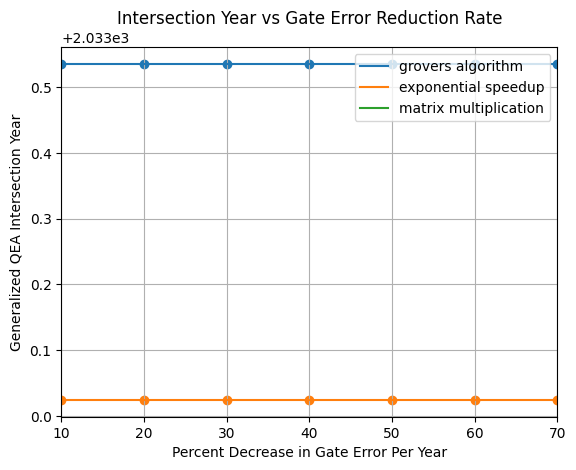

In [35]:
#now plot the intersection years vs error reduction
plt.plot(error_reduction_ranges*100, intersection_results_error_reduction["Grover's Algorithm"], label="grovers algorithm")
plt.scatter(error_reduction_ranges*100, intersection_results_error_reduction["Grover's Algorithm"])
plt.plot(error_reduction_ranges*100, intersection_results_error_reduction["Exponential Speedup"], label="exponential speedup")
plt.scatter(error_reduction_ranges*100, intersection_results_error_reduction["Exponential Speedup"])
plt.plot(error_reduction_ranges*100, intersection_results_error_reduction["Matrix Multiplication"], label="matrix multiplication")
plt.scatter(error_reduction_ranges*100, intersection_results_error_reduction["Matrix Multiplication"])
plt.ylabel("Generalized QEA Intersection Year")
plt.xlabel("Percent Decrease in Gate Error Per Year")
plt.xlim(10, 70)
plt.title("Intersection Year vs Gate Error Reduction Rate")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig("Figures/intersection_year_vs_error_reduction_rate.png")
plt.show()


In [15]:

fidelity_improvement_rate = 0.28
gate_speed_improvement_rate = 0.14
classical_speed_init = 1 / (1.5 * 1e9)  #
superconducting_gate_speed_init = 1e-6  # (1/(1.5*1e9))*(10**3.78) # seconds #overhead taken from quantum economic advantage calculator
initial_error = 10 ** (-2.5)
classical_speed_improvement_rate = 0.3  # moore's law improvement
number_of_processors = 1e8  # processor overehead done from calculations for GPU
connectivity_penalty_exponent = 0.0  # connectivity penalty for physical to logical qubit ratio in this range. default no 
time_upper_limit = (3.14 * 1e7) / 12  # 1 month computation time
scode_init_speed_overhead = 1e2  # slowdown overhead from Choi, Neil, and Moses
alg_overhead_qubit = 1e0  # algorithm overhead in logical qubits
alg_overhead_qspeed = 1e0  # algorithm speed overhead based on constants this is exclusivly for quantum algorithm
classical_alg_overhead = 1e0
default_roadmap = percentile_90_roadmap

def create_roadmap(growth_rate, init_qubits=305.13, start_year=2024, num_years=10):
    return {start_year + i: int(init_qubits * (growth_rate)**i) for i in range(num_years)}


# Get initial intersection years
initial_years = []
for classical_rt, quantum_rt, name in runtime_pairs:
    year = get_intersection_year(quantum_rt, classical_rt)
    initial_years.append(year)
    print(f"Initial intersection year for {name}: {year}")

# Analyze sensitivity to roadmap growth rate
growth_rates = np.arange(1.0, 1.9, 0.1)
intersection_results_roadmap = {name: [] for _, _, name in runtime_pairs}

for growth_rate in growth_rates:
    # Create a temporary roadmap with this growth rate
    temp_roadmap = create_roadmap(growth_rate)
    
    # Temporarily modify the global roadmap variable
    default_roadmap = temp_roadmap
    
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, start_year=MIN_YEAR, end_year=MAX_YEAR)
        intersection_results_roadmap[name].append(year)
    



Initial intersection year for Grover's Algorithm: 2033.5348307002278
Initial intersection year for Exponential Speedup: 2033.0245721976098
Initial intersection year for Matrix Multiplication: None


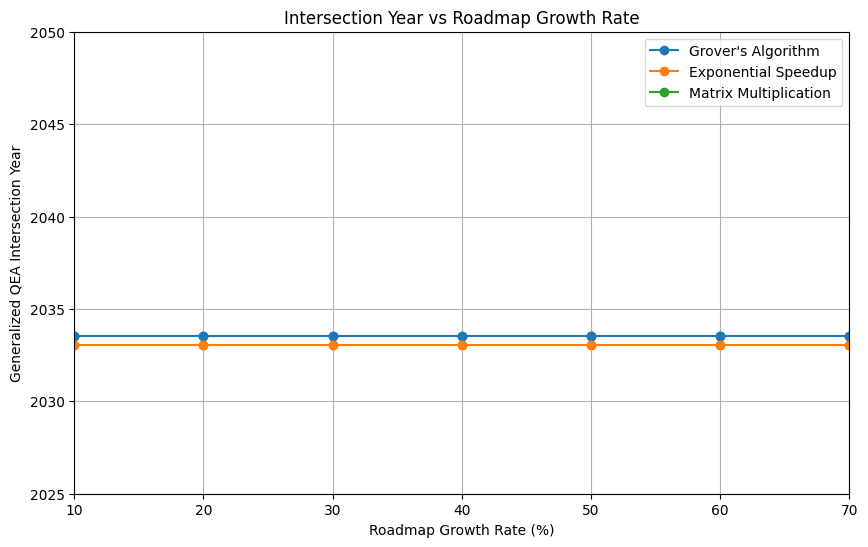

In [16]:

# Create plot
plt.figure(figsize=(10, 6))
for name in intersection_results_roadmap.keys():
    plt.plot([(rate-1)*100 for rate in growth_rates], 
             intersection_results_roadmap[name], 
             'o-', 
             label=name)
    plt.scatter([(rate-1)*100 for rate in growth_rates], 
                intersection_results_roadmap[name])

plt.ylabel("Generalized QEA Intersection Year")
plt.xlabel("Roadmap Growth Rate (%)")

plt.title("Intersection Year vs Roadmap Growth Rate")
plt.grid(True)
plt.xlim(10, 70)
plt.ylim(2025, 2050)
plt.legend(loc="upper right")
plt.savefig("Figures/intersection_year_vs_roadmap_growth_rate.png")
plt.show()

# Sensitivity Gate Speed Reduction Rate

In [17]:
# find the intersection of quantum max computable problem size and quantum economic advantage use binary search intersection 

# #constants in different format
fidelity_improvement_rate = 0.28
gate_speed_improvement_rate = 0.14
classical_speed_init = 1 / (1.5 * 1e9)  #
superconducting_gate_speed_init = 1e-6  # (1/(1.5*1e9))*(10**3.78) # seconds #overhead taken from quantum economic advantage calculator
initial_error = 10 ** (-2.5)
classical_speed_improvement_rate = 0.3  # moore's law improvement
number_of_processors = 1e8  # processor overehead done from calculations for GPUs
# time_upper_limt = 3.14*1e7 # 1-year of seconds
connectivity_penalty_exponent = 0.0  # connectivity penalty for physical to logical qubit ratio in this range. default no asymptotic connectivity penality
time_upper_limit = (3.14 * 1e7) / 12  # 1 month computation time
scode_init_speed_overhead = 1e2  # slowdown overhead from Choi, Neil, and Moses
alg_overhead_qubit = 1e0  # algorithm overhead in logical qubits
alg_overhead_qspeed = 1e0  # algorithm speed overhead based on constants this is exclusivly for quantum algorithm
classical_alg_overhead = 1e0
default_roadmap = percentile_90_roadmap


# First runtime pair: n vs n^0.5
# Define runtime pairs
runtime_pairs = [
    ("n", "n**.5", "Grover's Algorithm"),
    ("n", "log(n,2)", "Exponential Speedup"),
    ("n**3", "n**2", "Matrix Multiplication")
]
# Get initial intersection years
initial_years = []
for classical_rt, quantum_rt, name in runtime_pairs:
    year = get_intersection_year(quantum_rt, classical_rt)
    initial_years.append(year)
    print(f"Initial intersection year for {name}: {year}")

# Analyze sensitivity to error reduction rate
speed_improvement_ranges = np.arange(0.1, 0.8, 0.1)
intersection_results_speed_improvement = {name: [] for _, _, name in runtime_pairs}

for speed_improvement in speed_improvement_ranges:
    gate_speed_improvement_rate = speed_improvement
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, start_year=MIN_YEAR, end_year=MAX_YEAR)
        print(gate_speed_improvement_rate, year)
        intersection_results_speed_improvement[name].append(year)


Initial intersection year for Grover's Algorithm: 2033.5348307002278
Initial intersection year for Exponential Speedup: 2033.0245721976098
Initial intersection year for Matrix Multiplication: None
0.1 2033.5473510080192
0.1 2033.035241993639
0.1 None
0.2 2033.5146309247648
0.2 2033.0073891869688
0.2 None
0.30000000000000004 2033.4763883285632
0.30000000000000004 2032.974954231031
0.30000000000000004 None
0.4 2033.4306310825923
0.4 2032.9363293400093
0.4 2046.2704048484738
0.5 2033.3741229937004
0.5 2032.888863284461
0.5 2039.904253725399
0.6 2033.3011233517027
0.6 2032.82823560221
0.6 2036.1015199559915
0.7000000000000001 2033.200051572203
0.7000000000000001 2032.7468293668062
0.7000000000000001 2033.453642771201


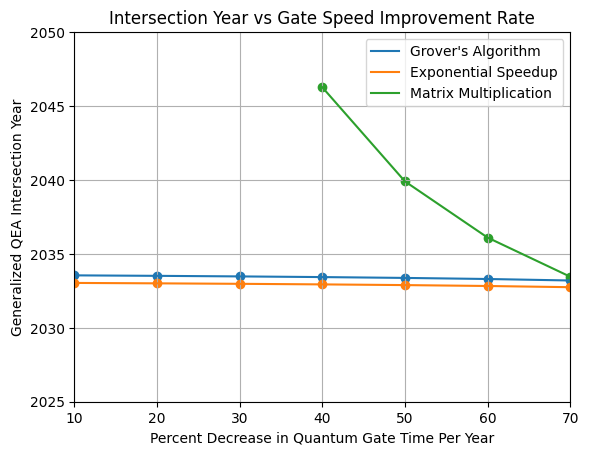

{"Grover's Algorithm": [2033.5473510080192, 2033.5146309247648, 2033.4763883285632, 2033.4306310825923, 2033.3741229937004, 2033.3011233517027, 2033.200051572203], 'Exponential Speedup': [2033.035241993639, 2033.0073891869688, 2032.974954231031, 2032.9363293400093, 2032.888863284461, 2032.82823560221, 2032.7468293668062], 'Matrix Multiplication': [None, None, None, 2046.2704048484738, 2039.904253725399, 2036.1015199559915, 2033.453642771201]}


In [18]:

plt.plot(speed_improvement_ranges*100, intersection_results_speed_improvement["Grover's Algorithm"], label="Grover's Algorithm")
plt.scatter(speed_improvement_ranges*100, intersection_results_speed_improvement["Grover's Algorithm"])
plt.plot(speed_improvement_ranges*100, intersection_results_speed_improvement["Exponential Speedup"], label="Exponential Speedup")
plt.scatter(speed_improvement_ranges*100, intersection_results_speed_improvement["Exponential Speedup"])
plt.plot(speed_improvement_ranges*100, intersection_results_speed_improvement["Matrix Multiplication"], label="Matrix Multiplication")
plt.scatter(speed_improvement_ranges*100, intersection_results_speed_improvement["Matrix Multiplication"])
plt.ylabel("Generalized QEA Intersection Year")
plt.xlabel("Percent Decrease in Quantum Gate Time Per Year")
plt.title("Intersection Year vs Gate Speed Improvement Rate")
plt.grid(True)
plt.ylim(2025, 2050)
plt.legend(loc="upper right")
plt.xlim(10, 70)
plt.savefig("Figures/intersection_year_vs_gate_speed_improvement_rate.png")
plt.show()


print(intersection_results_speed_improvement)



# Classical Improvement Rate Sensitivity 

In [19]:
# First runtime pair: n vs n^0.5

# #constants in different format
fidelity_improvement_rate = 0.28
gate_speed_improvement_rate = 0.14
classical_speed_init = 1 / (1.5 * 1e9)  #
superconducting_gate_speed_init = 1e-6  # (1/(1.5*1e9))*(10**3.78) # seconds #overhead taken from quantum economic advantage calculator
initial_error = 10 ** (-2.5)
classical_speed_improvement_rate = 0.3  # moore's law improvement
number_of_processors = 1e8  # processor overehead done from calculations for GPUs
# time_upper_limt = 3.14*1e7 # 1-year of seconds
connectivity_penalty_exponent = 0.0  # connectivity penalty for physical to logical qubit ratio in this range. default no asymptotic connectivity penality
time_upper_limit = 4 * (3.14 * 1e7) / 52  # 1 month computation time
scode_init_speed_overhead = 1e2  # slowdown overhead from Choi, Neil, and Moses
alg_overhead_qubit = 1e1  # algorithm overhead in logical qubits
alg_overhead_qspeed = 1e0  # algorithm speed overhead based on constants this is exclusivly for quantum algorithm
classical_alg_overhead = 1e0
default_roadmap = percentile_90_roadmap


# Get initial intersection years
initial_years = []
for classical_rt, quantum_rt, name in runtime_pairs:
    year = get_intersection_year(quantum_rt, classical_rt)
    initial_years.append(year)
    print(f"Initial intersection year for {name}: {year}")

# Analyze sensitivity to error reduction rate
classical_improvement_rates = np.arange(0.1, 0.7, 0.1)
intersection_results_classical_improvement_rate = {name: [] for _, _, name in runtime_pairs}

for classical_improvement_rate in classical_improvement_rates:
    classical_speed_improvement_rate = classical_improvement_rate
    for classical_rt, quantum_rt, name in runtime_pairs:
        year = get_intersection_year(quantum_rt, classical_rt, start_year=MIN_YEAR, end_year=MAX_YEAR)
        intersection_results_classical_improvement_rate[name].append(year)

Initial intersection year for Grover's Algorithm: 2035.6327864872583
Initial intersection year for Exponential Speedup: 2035.115250833769
Initial intersection year for Matrix Multiplication: None


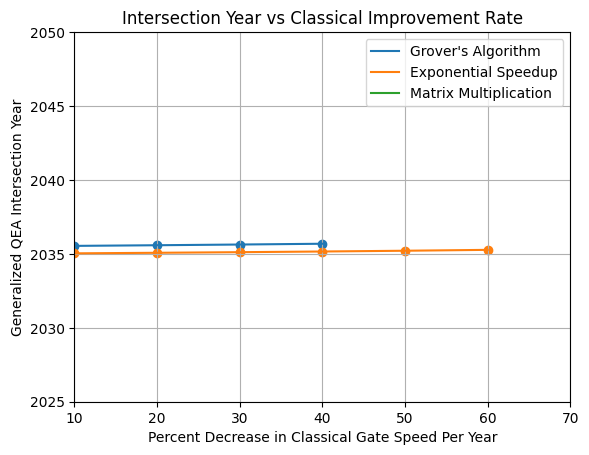

In [20]:
plt.plot(classical_improvement_rates*100, intersection_results_classical_improvement_rate["Grover's Algorithm"], label="Grover's Algorithm")
plt.scatter(classical_improvement_rates*100, intersection_results_classical_improvement_rate["Grover's Algorithm"])
plt.plot(classical_improvement_rates*100, intersection_results_classical_improvement_rate["Exponential Speedup"], label="Exponential Speedup")
plt.scatter(classical_improvement_rates*100, intersection_results_classical_improvement_rate["Exponential Speedup"])
plt.plot(classical_improvement_rates*100, intersection_results_classical_improvement_rate["Matrix Multiplication"], label="Matrix Multiplication")
plt.scatter(classical_improvement_rates*100, intersection_results_classical_improvement_rate["Matrix Multiplication"])
plt.ylabel("Generalized QEA Intersection Year")
plt.xlabel("Percent Decrease in Classical Gate Speed Per Year")
plt.title("Intersection Year vs Classical Improvement Rate")
plt.grid(True)
plt.ylim(2025, 2050)
plt.xlim(10, 70)
plt.legend(loc="upper right")
plt.savefig("Figures/intersection_year_vs_classical_improvement_rate.png")
plt.show()



# Combined Graph

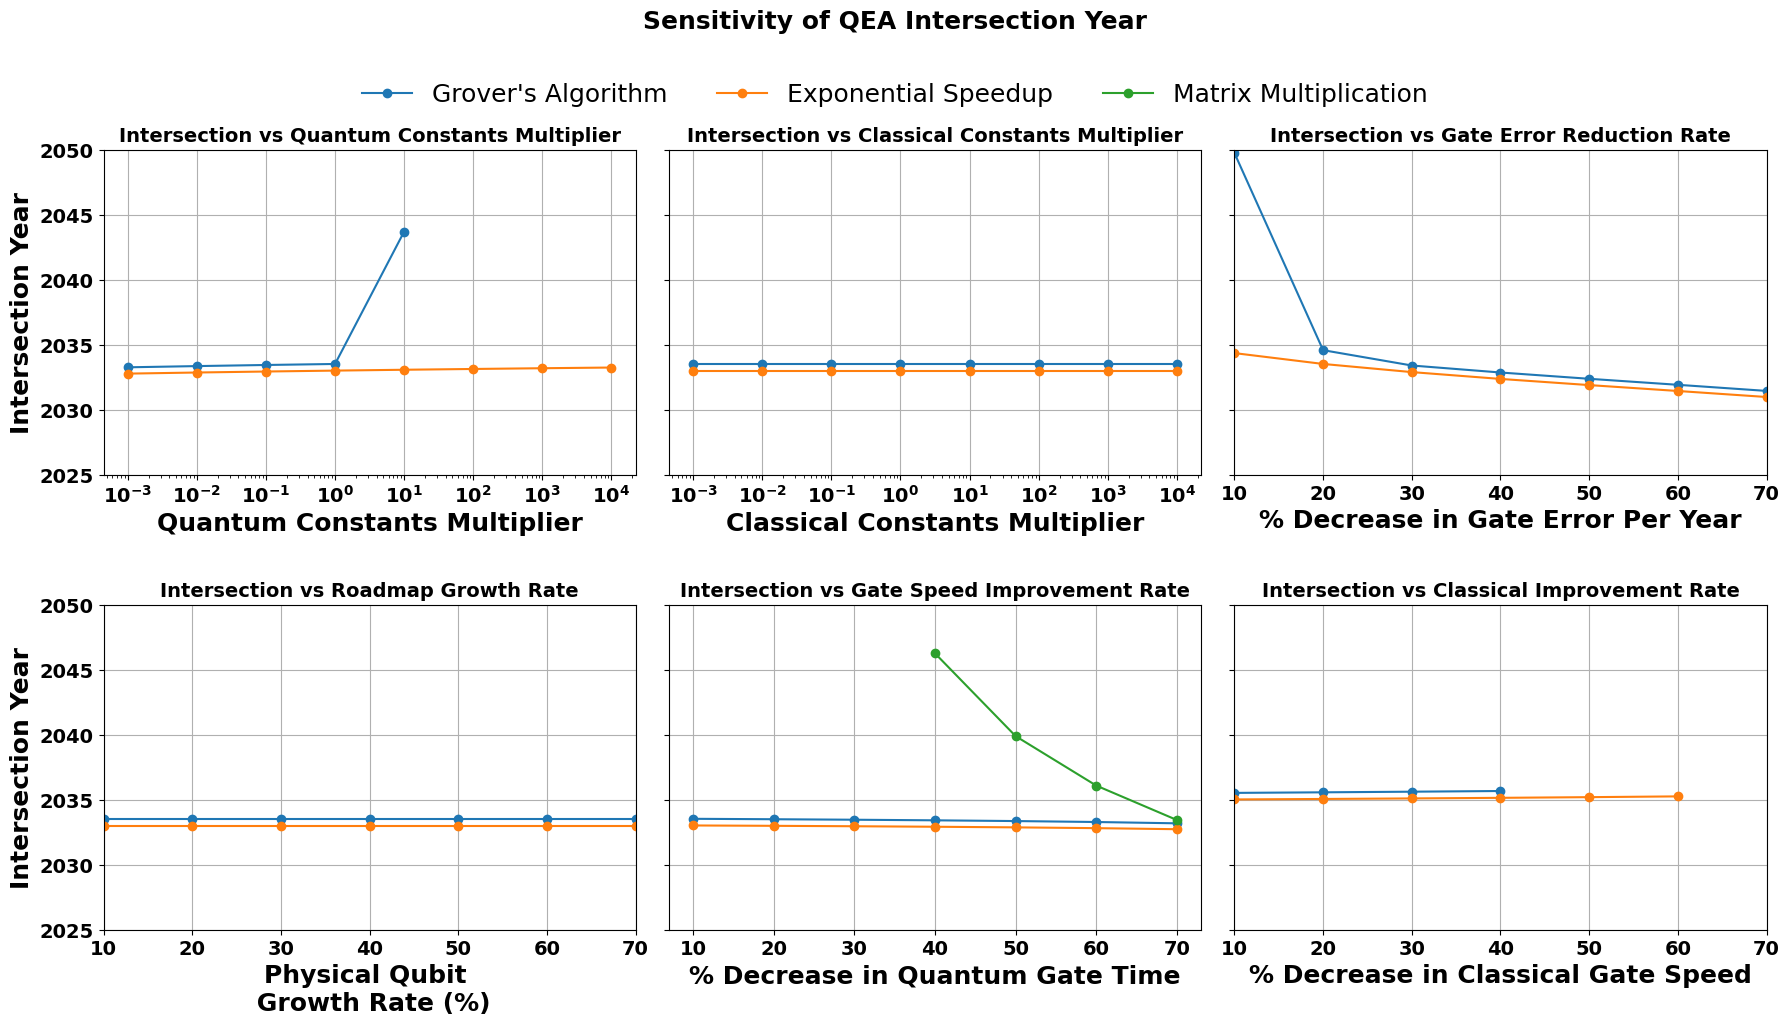

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have already defined:
#   constant_variations
#   intersection_results_quantum_constants
#   intersection_results_classical_constants
#   error_reduction_ranges, intersection_results_error_reduction
#   growth_rates, intersection_results_roadmap
#   speed_improvement_ranges, intersection_results_speed_improvement
#   classical_improvement_rates, intersection_results_classical_improvement_rate

# Pack each subplot's config into a dict
configs = [
    dict(
        title="Intersection vs Quantum Constants Multiplier",
        x=constant_variations,
        xlabel="Quantum Constants Multiplier",
        xscale="log",
        data=intersection_results_quantum_constants
    ),
    dict(
        title="Intersection vs Classical Constants Multiplier",
        x=constant_variations,
        xlabel="Classical Constants Multiplier",
        xscale="log",
        data=intersection_results_classical_constants
    ),
    dict(
        title="Intersection vs Gate Error Reduction Rate",
        x=error_reduction_ranges * 100,
        xlabel="% Decrease in Gate Error Per Year",
        xlim=(10,70),
        data=intersection_results_error_reduction
    ),
    dict(
        title="Intersection vs Roadmap Growth Rate",
        x=(growth_rates - 1) * 100,
        xlabel="Physical Qubit \n Growth Rate (%)",
        xlim=(10,70),
        data=intersection_results_roadmap
    ),
    dict(
        title="Intersection vs Gate Speed Improvement Rate",
        x=speed_improvement_ranges * 100,
        xlabel="% Decrease in Quantum Gate Time",
        data=intersection_results_speed_improvement
    ),
    dict(
        title="Intersection vs Classical Improvement Rate",
        x=classical_improvement_rates * 100,
        xlabel="% Decrease in Classical Gate Speed",
        xlim=(10,70),
        data=intersection_results_classical_improvement_rate
    ),
]

# Create the 2×3 panel
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axes = axes.ravel()

for ax, cfg in zip(axes, configs):
    x = cfg['x']
    for name in ("Grover's Algorithm", "Exponential Speedup", "Matrix Multiplication"):
        y = cfg['data'][name]
        ax.plot(x, y, 'o-', label=name, markersize=6)
    ax.set_title(cfg['title'], fontsize=14, fontweight='bold')
    ax.set_xlabel(cfg['xlabel'], fontsize=18, fontweight='bold')
    if 'xscale' in cfg:
        ax.set_xscale(cfg['xscale'])
    if 'xlim' in cfg:
        ax.set_xlim(*cfg['xlim'])
    ax.grid(True)

# Y‐axis label on leftmost plots
axes[0].set_ylabel("Intersection Year", fontsize=18, fontweight='bold')
axes[3].set_ylabel("Intersection Year", fontsize=18, fontweight='bold')

# Shared Y‐limits
for ax in axes:
    ax.set_ylim(MIN_YEAR, MAX_YEAR)
    ax.tick_params(labelsize=14)
    for lbl in ax.get_yticklabels()+ax.get_xticklabels():
        lbl.set_fontweight('bold')

# One legend for all - moved down to avoid overlapping with title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.97),
           ncol=3, fontsize=18, frameon=False)

fig.suptitle("Sensitivity of QEA Intersection Year", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()

# Add more space between top and bottom rows
plt.subplots_adjust(top=0.88, bottom=0.10, hspace=0.4)
plt.savefig("Figures/intersection_sensitivity_overview.png", dpi=300)
plt.show()